# Описание задачи

Cоздать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

import random

from sklearn.model_selection import(
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import(
    OneHotEncoder,
    StandardScaler
)

from sklearn.metrics import(
    recall_score as rec,
    confusion_matrix,
    precision_recall_curve
)


from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sqlalchemy import create_engine, text 

import warnings
warnings.filterwarnings("ignore")

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Подключитесь к базе. Загрузите таблицы sql

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [4]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

Изучаем:

### Таблица `case_ids`:

В таблице case_ids есть дуюлирующий неинформативный столбец `Case_id`, не станем его выгружать:

In [5]:
query = '''
SELECT
    case_id
FROM case_ids
LIMIT 10
'''

In [6]:
case_ids = pd.DataFrame(engine.connect().execute(text(query)))

In [7]:
case_ids

,case_id
0,0081715
1,0726202
2,3858022
3,3899441
4,3899442
5,3899445
6,3899446
7,3899449
8,3899450
9,3899453


Пропущенные значения:

In [8]:
query = '''
SELECT
     COUNT(*)
FROM 
    case_ids
WHERE
    case_id IS NULL
'''

In [9]:
case_ids = pd.DataFrame(engine.connect().execute(text(query)))

In [10]:
case_ids

,count
0,0


Их нет.

### Таблица `vehicles`:

Неинформативных столбцов нет.

In [11]:
query = '''
SELECT
    *
FROM
    vehicles
LIMIT 10
'''

In [12]:
vehicles = pd.DataFrame(engine.connect().execute(text(query)))

In [13]:
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Пропущенные значения по `case_id` и `party_number`:

In [14]:
query = '''
SELECT
     COUNT(*)
FROM
    vehicles
WHERE
    case_id IS NULL OR
    party_number IS NULL
'''

In [15]:
vehicles = pd.DataFrame(engine.connect().execute(text(query)))

In [16]:
vehicles

,count
0,0


Их нет.

### Таблица `collisions`:

Неинформативных столбцов нет.

In [17]:
query = '''
SELECT
    *
FROM
    collisions
LIMIT 10
'''

In [18]:
collisions = pd.DataFrame(engine.connect().execute(text(query)))

In [19]:
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


Пропущенные значения по `case_id`:

In [20]:
query = '''
SELECT
     COUNT(*)
FROM
    collisions
WHERE
    case_id IS NULL
'''

In [21]:
collisions = pd.DataFrame(engine.connect().execute(text(query)))

In [22]:
collisions

,count
0,0


### Таблица `parties`:

Неинформативных столбцов нет.

In [23]:
query = '''
SELECT
    *
FROM
    parties
LIMIT 10
'''

In [24]:
parties = pd.DataFrame(engine.connect().execute(text(query)))

In [25]:
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Пропущенные значения по `case_id` и `party_number`:

In [26]:
query = '''
SELECT
     COUNT(*)
FROM
    parties
WHERE
    case_id IS NULL
'''

In [27]:
parties = pd.DataFrame(engine.connect().execute(text(query)))

In [28]:
parties

,count
0,0


*В условии задачи, не была указана таблица cases_ids.*

*Общий ключ для связи таблиц есть. Это `case_id`*.

##  Проведите статистический анализ факторов ДТП

### Дтп по месяцам:

Выясним, в какие месяцы происходит наибольшее количество аварий за весь период наблюдений:

In [29]:
query = '''
SELECT
    DISTINCT EXTRACT(MONTH from collision_date) AS month,
    COUNT(case_id) AS num_of_col
FROM
    collisions
GROUP BY
    EXTRACT(MONTH from collision_date)
'''

In [30]:
df = pd.DataFrame(engine.connect().execute(text(query)))

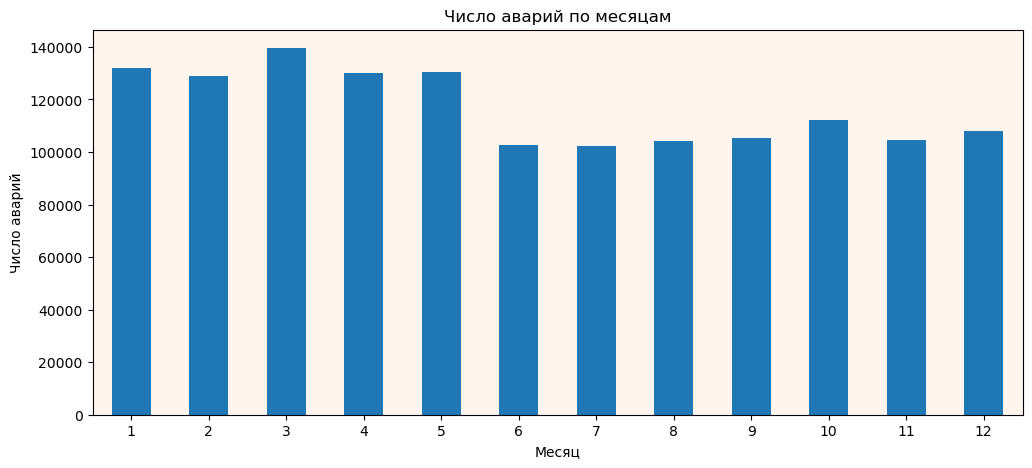

In [31]:
ax = df.plot.bar(x = 'month', y = 'num_of_col', rot=0, figsize=(12, 5), title='Число аварий по месяцам')

ax.set(xlabel = 'Месяц',
       ylabel = 'Число аварий')

ax.set_facecolor('seashell')

ax.get_legend().remove()

plt.show()

Видим, что наибольшее число аварий происходит зимой и весной. Причиной этому может быть непогода и большое число праздников. С другой стороны, непогода также должна была повлиять на число дтп осенью; этого почти не видно, если не брать в расчёт октябрь. 

### Задачи для коллег:

- Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП

- Найти самые частые причины ДТП

- Проверить гипотезу о том, что в январе-декабре подавляющее большинство нарушителей -- нетрезвые водители 

- В какое время суток чаще всего происходят ДТП? Проверить гипотезу о том, что самое опасное время -- сумерки и вечер

- Выяснить, какие клиенты с какой суммой страховки чаще всего попадают в серьёзные аварии?

- На каких типах/участках дорог чаще всего происходят ДТП?

**Решение задачи `Провести анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП`**

In [32]:
query = '''
SELECT
    collision_damage,
    road_surface,
    COUNT(*)
FROM
    collisions
GROUP BY
    collision_damage,
    road_surface
'''

In [33]:
df = pd.DataFrame(engine.connect().execute(text(query)))
df.head()

,collision_damage,road_surface,count
0,fatal,dry,9823
1,fatal,slippery,12
2,fatal,snowy,46
3,fatal,wet,857
4,fatal,None,55


In [34]:
df = df.pivot('collision_damage', 'road_surface', 'count')

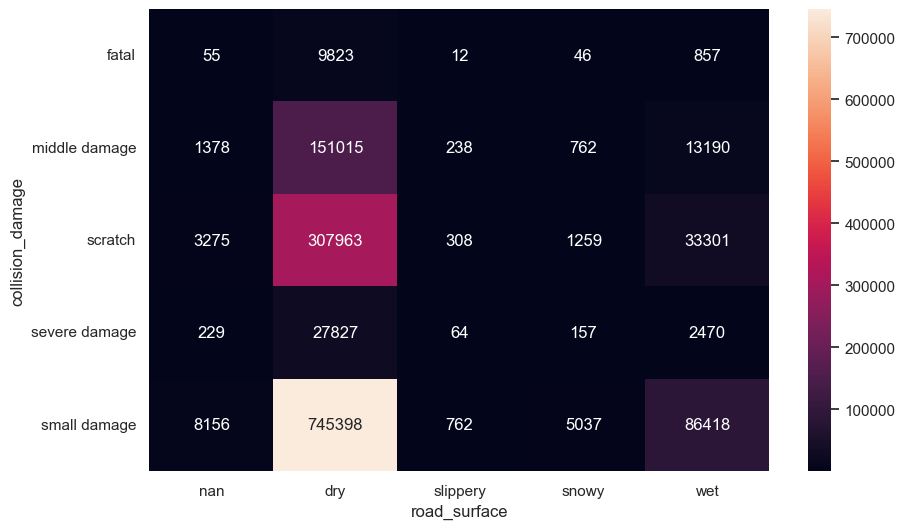

In [35]:
sns.set(rc={"figure.figsize":(10, 6)})
sns.heatmap(df, annot=True, fmt="d", annot_kws={"size":12});

Больше всего повреждений во время `dry`. Это можно объяснить тем, что чаще всего такая погода и стоит. Если не рассматривать это состояние дороги, то чётко видна корреляция: число всех видов повреждений растёт при ухудшении погоды. 

**Решение задачи `Найти самые частые причины ДТП`**

In [36]:
query = '''
SELECT
    primary_collision_factor,
    COUNT(*)
FROM
    collisions
GROUP BY
    primary_collision_factor
'''

In [37]:
df = pd.DataFrame(engine.connect().execute(text(query)))

In [38]:
df

,primary_collision_factor,count
0,fell asleep,117
1,other improper driving,8470
2,other than driver,29780
3,unknown,37014
4,vehicle code violation,1316453
5,None,8166


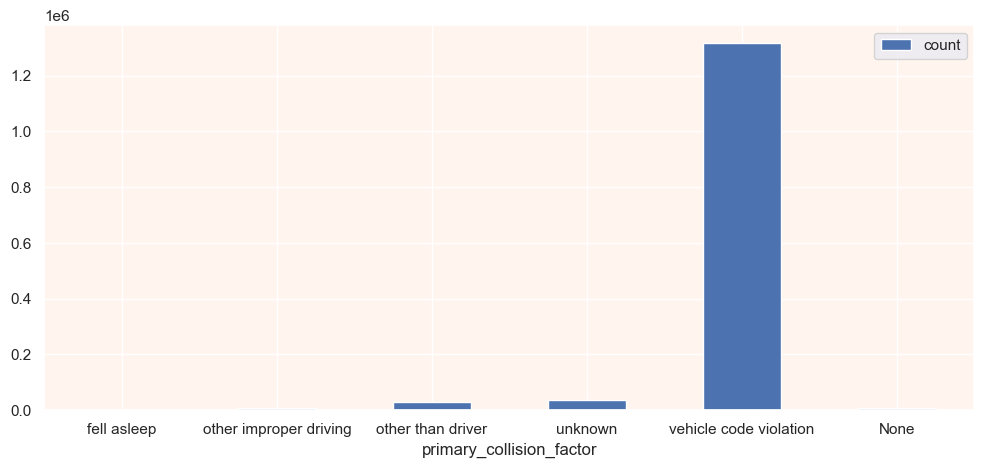

In [39]:
ax = df.plot.bar(x = 'primary_collision_factor', y = 'count', rot=0, figsize=(12, 5))

ax.set_facecolor('seashell')

plt.show()

Итак, основной причиной аварий является нарушение ПДД

**Решение задачи `Выяснить, какие клиенты с какой суммой страховки чаще всего попадают в серьёзные аварии?`.**

In [40]:
query = '''
SELECT
    p.insurance_premium AS insurance
FROM
    collisions AS c INNER JOIN
    parties AS p ON c.case_id = p.case_id
WHERE 
    p.at_fault = 1 AND
    c.collision_damage != 'scratch' AND
    c.collision_damage != 'small damage'
'''

In [41]:
df = pd.DataFrame(engine.connect().execute(text(query)))

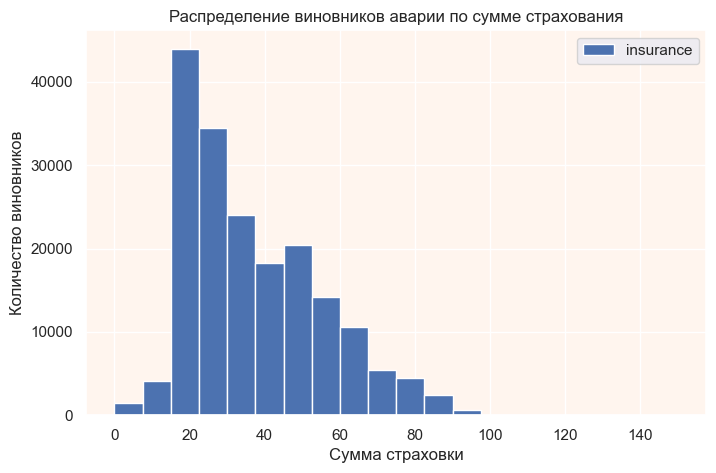

In [42]:
ax = df.plot.hist(bins=20, range=(0, 150), figsize=(8, 5), title='Распределение виновников аварии по сумме страхования');

ax.set(xlabel = 'Сумма страховки',
       ylabel = 'Количество виновников')

ax.set_facecolor('seashell')

plt.show()

Особенностей не наблюдается: чаще всего в аварии попадают клиенты со стандартной (как я понимаю) суммой страховки. Вероятно, из-за того, что их банально больше. Хотя и виднеется небольшой всплеск в районе 50.

**Решение задачи `Проверить гипотезу о том, что в январе-декабре подавляющее большинство нарушителей -- нетрезвые водители`:**

In [43]:
query = '''
SELECT
    p.party_sobriety,
    COUNT(*)
FROM
    collisions AS c INNER JOIN
    parties AS p ON c.case_id = p.case_id
WHERE 
    p.at_fault = 1 AND
    (EXTRACT(MONTH FROM c.collision_date) = 12.0 OR
    EXTRACT(MONTH FROM c.collision_date) = 1.0) AND
    p.party_sobriety != 'impairment unknown' AND
    p.party_sobriety != 'not applicable' AND
    p.party_sobriety IS NOT NULL
GROUP BY
    p.party_sobriety
'''

In [44]:
df = pd.DataFrame(engine.connect().execute(text(query)))

In [45]:
df

,party_sobriety,count
0,"had been drinking, impairment unknown",3048
1,"had been drinking, not under influence",1987
2,"had been drinking, under influence",18375
3,had not been drinking,159301


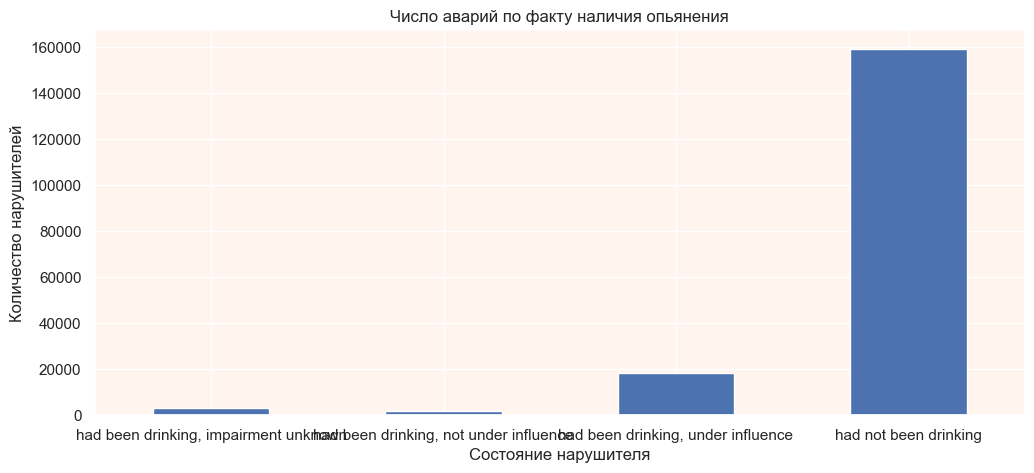

In [46]:
ax = df.plot.bar(x = 'party_sobriety', y = 'count',\
                 rot=0, figsize=(12, 5), title='Число аварий по факту наличия опьянения')

ax.set(xlabel = 'Состояние нарушителя',
       ylabel = 'Количество нарушителей')

ax.set_facecolor('seashell')

ax.get_legend().remove()

plt.show()

Нетрезвых нарушителей немало, но гораздо меньше, чем тех, кто не пил.

## Создайте модель для оценки водительского риска

### Выгрузим данные в датафрейм и выполним предобработаку:

Выгрузим необходимые для обучения данные в таблицу `df`:

In [47]:
query = '''
SELECT
    c.distance,
    c.intersection,
    c.weather_1,
    c.location_type,
    c.road_surface,
    c.road_condition_1,
    c.lighting,
    p.at_fault,
    p.party_sobriety,
    p.party_drug_physical,
    p.cellphone_in_use,
    v.vehicle_type,
    v.vehicle_transmission,
    v.vehicle_age    
FROM
    collisions AS c INNER JOIN
    parties AS p ON c.case_id = p.case_id INNER JOIN
    vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE
    p.party_type = 'car' AND
    c.collision_damage != 'scratch' AND
    EXTRACT(YEAR FROM c.collision_date) = 2012
'''

In [48]:
%%time
df = pd.DataFrame(engine.connect().execute(text(query)))

CPU times: user 544 ms, sys: 90.7 ms, total: 635 ms
Wall time: 8.65 s


In [49]:
df.shape

(56248, 14)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   intersection          56073 non-null  float64
 2   weather_1             56080 non-null  object 
 3   location_type         25932 non-null  object 
 4   road_surface          55900 non-null  object 
 5   road_condition_1      55999 non-null  object 
 6   lighting              56094 non-null  object 
 7   at_fault              56248 non-null  int64  
 8   party_sobriety        55376 non-null  object 
 9   party_drug_physical   2857 non-null   object 
 10  cellphone_in_use      51777 non-null  float64
 11  vehicle_type          56248 non-null  object 
 12  vehicle_transmission  55389 non-null  object 
 13  vehicle_age           54554 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 6.0+ MB


Отберём необходимые признаки, которые могут влиять на ДТП:

In [51]:
columns =[  'distance',     # Расстояние до главной дороги может влиять. Таблица collisions
            'intersection', # Наличие перекрёстков на пути может влиять на вероятность аварии. Таблица collisions
            'weather_1', # Погодные условия могут влиять на вероятность на дтп. Таблица collisions
            'location_type', # Тип дороги может влиять на вероятность на дтп. Таблица collisions
            'road_surface', # Погодное поверхности дороги могут влиять на дтп. Таблица collisions
            'road_condition_1', # Ремонтное состояние поверхности дороги могут влиять на дтп. Таблица collisions
            'lighting', # Освещённость дороги может влиять на дтп. Таблица collisions
            'at_fault', # Целевой признак
            'party_sobriety', # Алкогольное опьянение влияет. Таблица parties
            'party_drug_physical', #Состояние от приёма лекарств влияет. Таблица parties
            'cellphone_in_use', #Наличие возможности говорить по телефону может влиять
            'vehicle_type', #Тип авто может влиять -- на грузовиках трудно ехать
            'vehicle_transmission', #На механике ехать сложнее, чем на автомате
            'vehicle_age' #Возраст может влиять
         ] 

In [52]:
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   intersection          56073 non-null  float64
 2   weather_1             56080 non-null  object 
 3   location_type         25932 non-null  object 
 4   road_surface          55900 non-null  object 
 5   road_condition_1      55999 non-null  object 
 6   lighting              56094 non-null  object 
 7   at_fault              56248 non-null  int64  
 8   party_sobriety        55376 non-null  object 
 9   party_drug_physical   2857 non-null   object 
 10  cellphone_in_use      51777 non-null  float64
 11  vehicle_type          56248 non-null  object 
 12  vehicle_transmission  55389 non-null  object 
 13  vehicle_age           54554 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 6.0+ MB


В графе `location_type` и `party_drug_physical` очень много пропусков. Восстановить их разумных образом нет возможности. Исключим эти столбцы из рассмотрения:

In [53]:
df.drop(['location_type', 'party_drug_physical'], axis=1, inplace=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   intersection          56073 non-null  float64
 2   weather_1             56080 non-null  object 
 3   road_surface          55900 non-null  object 
 4   road_condition_1      55999 non-null  object 
 5   lighting              56094 non-null  object 
 6   at_fault              56248 non-null  int64  
 7   party_sobriety        55376 non-null  object 
 8   cellphone_in_use      51777 non-null  float64
 9   vehicle_type          56248 non-null  object 
 10  vehicle_transmission  55389 non-null  object 
 11  vehicle_age           54554 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 5.1+ MB


Посмотрим на процент пропусков в столбце `cellphone_in_use`: 

In [55]:
print(round(df['cellphone_in_use'].isna().sum()/ df['cellphone_in_use'].count() * 100, 1), '%')

8.6 %


Слишком велик процент по сравнению с общим объёмом. Исключим этот столбец, чтобы избежать ошибок во время обучения:

In [56]:
df.drop(['cellphone_in_use'], axis=1, inplace=True)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              56248 non-null  float64
 1   intersection          56073 non-null  float64
 2   weather_1             56080 non-null  object 
 3   road_surface          55900 non-null  object 
 4   road_condition_1      55999 non-null  object 
 5   lighting              56094 non-null  object 
 6   at_fault              56248 non-null  int64  
 7   party_sobriety        55376 non-null  object 
 8   vehicle_type          56248 non-null  object 
 9   vehicle_transmission  55389 non-null  object 
 10  vehicle_age           54554 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.7+ MB


В остальных столбцах пропусков мало. Просто исключим соответствующие строки:

In [58]:
df = df[~df.isnull().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52337 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              52337 non-null  float64
 1   intersection          52337 non-null  float64
 2   weather_1             52337 non-null  object 
 3   road_surface          52337 non-null  object 
 4   road_condition_1      52337 non-null  object 
 5   lighting              52337 non-null  object 
 6   at_fault              52337 non-null  int64  
 7   party_sobriety        52337 non-null  object 
 8   vehicle_type          52337 non-null  object 
 9   vehicle_transmission  52337 non-null  object 
 10  vehicle_age           52337 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.8+ MB


### Проверим столбцы на наличие аномалий:

#### Столбец `distance`:

In [59]:
df.distance.describe()

count    5.233700e+04
mean     8.824403e+02
std      7.478005e+03
min      0.000000e+00
25%      1.000000e+01
50%      1.500000e+02
75%      6.000000e+02
max      1.584000e+06
Name: distance, dtype: float64

Для более подробного изучения построим диаграмму размаха:

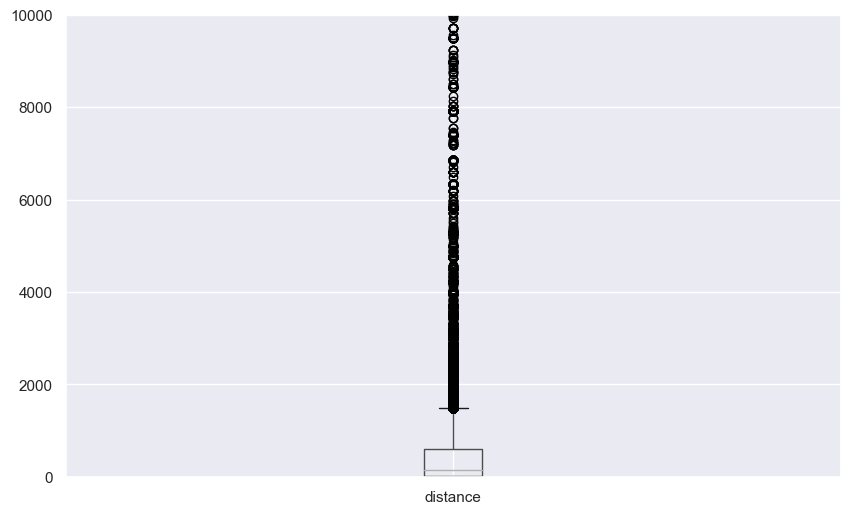

In [60]:
plt.ylim(0, 1e4)
plt.xlim(0, 2) 
df.boxplot(column='distance');

Выше верхнего уса лежит большое количество выбросов. Посмотрим на значения, которые лежат выше верхнего уса:

In [61]:
Q1 = df['distance'].quantile(0.25)
Q3 = df['distance'].quantile(0.75)
IQR = Q3 - Q1
df[df['distance'] > Q3 + 1.5*IQR]['distance'].sort_values().to_frame()

,distance
14968,1489.0
44142,1492.0
52697,1492.0
54310,1493.0
30783,1500.0
...,...
52774,79200.0
44219,79200.0
29518,124080.0
25520,171600.0


Посмотрим на процент происшествий, случившихся на расстоянии более чем 10 км от главной дороги:

In [62]:
print(round(df[df['distance'] > 10000]['distance'].count()/ df['distance'].count() * 100, 2), '%')

1.34 %


Их весьма мало. Исключим аномалии:

In [63]:
df = df[df['distance'] <= 10000]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51634 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51634 non-null  float64
 1   intersection          51634 non-null  float64
 2   weather_1             51634 non-null  object 
 3   road_surface          51634 non-null  object 
 4   road_condition_1      51634 non-null  object 
 5   lighting              51634 non-null  object 
 6   at_fault              51634 non-null  int64  
 7   party_sobriety        51634 non-null  object 
 8   vehicle_type          51634 non-null  object 
 9   vehicle_transmission  51634 non-null  object 
 10  vehicle_age           51634 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.7+ MB


#### Столбец `intersection`:

In [65]:
df.intersection.describe()

count    51634.000000
mean         0.219545
std          0.413943
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: intersection, dtype: float64

In [66]:
df.intersection.unique()

array([0., 1.])

In [67]:
df.intersection = df.intersection.astype('int64')

Аномалий не наблюдается.

#### Столбец `weather_1`:

In [68]:
df.weather_1.describe()

count     51634
unique        7
top       clear
freq      41500
Name: weather_1, dtype: object

In [69]:
df.weather_1.unique()

array(['cloudy', 'clear', 'raining', 'snowing', 'fog', 'wind', 'other'],
      dtype=object)

Аномалий не наблюдается.

Категория `other` кажется исключающейся из списка. Проверим, каков процент записей с таким значением от общего числа: 

In [70]:
print(round(100 * df[df.weather_1 == 'other'].at_fault.count() / df.at_fault.count(), 2), '%')

0.05 %


Очень мало, исключим шум:

In [71]:
df = df[df.weather_1 != 'other']

In [72]:
df.weather_1.unique()

array(['cloudy', 'clear', 'raining', 'snowing', 'fog', 'wind'],
      dtype=object)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51606 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51606 non-null  float64
 1   intersection          51606 non-null  int64  
 2   weather_1             51606 non-null  object 
 3   road_surface          51606 non-null  object 
 4   road_condition_1      51606 non-null  object 
 5   lighting              51606 non-null  object 
 6   at_fault              51606 non-null  int64  
 7   party_sobriety        51606 non-null  object 
 8   vehicle_type          51606 non-null  object 
 9   vehicle_transmission  51606 non-null  object 
 10  vehicle_age           51606 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.7+ MB


#### Столбец `road_surface`:

In [74]:
df.road_surface.describe()

count     51606
unique        4
top         dry
freq      46397
Name: road_surface, dtype: object

In [75]:
df.road_surface.unique()

array(['dry', 'wet', 'slippery', 'snowy'], dtype=object)

Аномалий не наблюдается.

#### Столбец `road_condition_1`:

In [76]:
df.road_condition_1.describe()

count      51606
unique         8
top       normal
freq       49935
Name: road_condition_1, dtype: object

In [77]:
df.road_condition_1.unique()

array(['normal', 'construction', 'other', 'loose material', 'holes',
       'obstruction', 'reduced width', 'flooded'], dtype=object)

Аномалий не наблюдается.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51606 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51606 non-null  float64
 1   intersection          51606 non-null  int64  
 2   weather_1             51606 non-null  object 
 3   road_surface          51606 non-null  object 
 4   road_condition_1      51606 non-null  object 
 5   lighting              51606 non-null  object 
 6   at_fault              51606 non-null  int64  
 7   party_sobriety        51606 non-null  object 
 8   vehicle_type          51606 non-null  object 
 9   vehicle_transmission  51606 non-null  object 
 10  vehicle_age           51606 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.7+ MB


#### Столбец `lighting`:

In [79]:
df.lighting.describe()

count        51606
unique           5
top       daylight
freq         35074
Name: lighting, dtype: object

In [80]:
df.lighting.unique()

array(['dusk or dawn', 'daylight', 'dark with street lights',
       'dark with no street lights',
       'dark with street lights not functioning'], dtype=object)

Категории `dark with no street lights` и `dark with street lights not functioning` можно объединить в одну:

In [81]:
df.lighting.replace({'dark with street lights not functioning':\
                           'dark with no street lights'}, inplace = True)

In [82]:
df.lighting.unique()

array(['dusk or dawn', 'daylight', 'dark with street lights',
       'dark with no street lights'], dtype=object)

Аномалий не наблюдается.

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51606 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51606 non-null  float64
 1   intersection          51606 non-null  int64  
 2   weather_1             51606 non-null  object 
 3   road_surface          51606 non-null  object 
 4   road_condition_1      51606 non-null  object 
 5   lighting              51606 non-null  object 
 6   at_fault              51606 non-null  int64  
 7   party_sobriety        51606 non-null  object 
 8   vehicle_type          51606 non-null  object 
 9   vehicle_transmission  51606 non-null  object 
 10  vehicle_age           51606 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.7+ MB


#### Столбец `party_sobriety`:

In [84]:
df.party_sobriety.describe()

count                     51606
unique                        6
top       had not been drinking
freq                      45385
Name: party_sobriety, dtype: object

In [85]:
df.party_sobriety.unique()

array(['had not been drinking', 'had been drinking, under influence',
       'impairment unknown', 'not applicable',
       'had been drinking, not under influence',
       'had been drinking, impairment unknown'], dtype=object)

Признаков с подтверждённым фактом опьянения достаточно много. Хотелось бы их объединить в один. Но для этого сначала проверим, в скольких процентах случаев пьяный водитель был виновником аварии:

Опьянённых виновников:

In [86]:
drunken_bastards = ((df.party_sobriety != 'impairment unknown') & (df.party_sobriety != 'not applicable')\
   & (df.party_sobriety != 'had not been drinking') & (df.at_fault == 1)).sum()
drunken_bastards

4611

Опьянённых невиновников:

In [87]:
drunken_pre_bastards = ((df.party_sobriety != 'impairment unknown') & (df.party_sobriety != 'not applicable')\
   & (df.party_sobriety != 'had not been drinking') & (df.at_fault == 0)).sum()
drunken_pre_bastards

357

Процент виновников среди всех опьянённых:

In [88]:
print(round(100 * drunken_bastards / (drunken_bastards + drunken_pre_bastards), 2), '%')

92.81 %


Процент опьянённых невиновников к числу во всём датасете:

In [89]:
print(round(100 * drunken_pre_bastards / len(df.at_fault), 2), '%')

0.69 %


Теперь без зазрения совести выкинем всех пьяных невиновников из датасета, после чего всех опьянённых объединим в одну категорию: так нейросети будет проще обучаться:

In [90]:
df = df[~((df.party_sobriety != 'impairment unknown') & (df.party_sobriety != 'not applicable')\
   & (df.party_sobriety != 'had not been drinking') & (df.at_fault == 0))]

In [91]:
df.party_sobriety.unique()

array(['had not been drinking', 'had been drinking, under influence',
       'impairment unknown', 'not applicable',
       'had been drinking, not under influence',
       'had been drinking, impairment unknown'], dtype=object)

Теперь заменим названия:

In [92]:
df.party_sobriety.replace({'had been drinking, under influence': 'had been drinking',\
                       'had been drinking, impairment unknown': 'had been drinking',\
                       'had been drinking, not under influence': 'had been drinking'}, inplace = True)

In [93]:
df.party_sobriety.unique()

array(['had not been drinking', 'had been drinking', 'impairment unknown',
       'not applicable'], dtype=object)

Проверим, каков процент участников от общего числа имеют статус `impairment unknown` или `not applicable`:

In [94]:
print(round(100 * df[(df.party_sobriety == 'impairment unknown') | (df.party_sobriety == 'not applicable')]\
            .at_fault.count() / df.at_fault.count(), 2), '%')

2.44 %


Весьма много. Проверим, сколько процентов каждого вида:

`impairment unknown`:

In [95]:
print(round(100 * df[(df.party_sobriety == 'impairment unknown')]\
            .at_fault.count() / df.at_fault.count(), 2), '%')

2.01 %


Таких много, не тронем эту категорию.

`not applicable`:

In [96]:
print(round(100 * df[(df.party_sobriety == 'not applicable')]\
            .at_fault.count() / df.at_fault.count(), 2), '%')

0.43 %


Таких мало, исключим шум:

In [97]:
df = df[df.party_sobriety != 'not applicable']
df.party_sobriety.unique()

array(['had not been drinking', 'had been drinking', 'impairment unknown'],
      dtype=object)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51028 entries, 1 to 56247
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51028 non-null  float64
 1   intersection          51028 non-null  int64  
 2   weather_1             51028 non-null  object 
 3   road_surface          51028 non-null  object 
 4   road_condition_1      51028 non-null  object 
 5   lighting              51028 non-null  object 
 6   at_fault              51028 non-null  int64  
 7   party_sobriety        51028 non-null  object 
 8   vehicle_type          51028 non-null  object 
 9   vehicle_transmission  51028 non-null  object 
 10  vehicle_age           51028 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.7+ MB


In [99]:
df.reset_index(drop=True, inplace=True)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51028 entries, 0 to 51027
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51028 non-null  float64
 1   intersection          51028 non-null  int64  
 2   weather_1             51028 non-null  object 
 3   road_surface          51028 non-null  object 
 4   road_condition_1      51028 non-null  object 
 5   lighting              51028 non-null  object 
 6   at_fault              51028 non-null  int64  
 7   party_sobriety        51028 non-null  object 
 8   vehicle_type          51028 non-null  object 
 9   vehicle_transmission  51028 non-null  object 
 10  vehicle_age           51028 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.3+ MB


#### Столбец `vehicle_age`:

In [101]:
df.vehicle_age.describe()

count    51028.000000
mean         4.840793
std          3.247647
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

Для более подробного изучения построим диаграмму размаха:

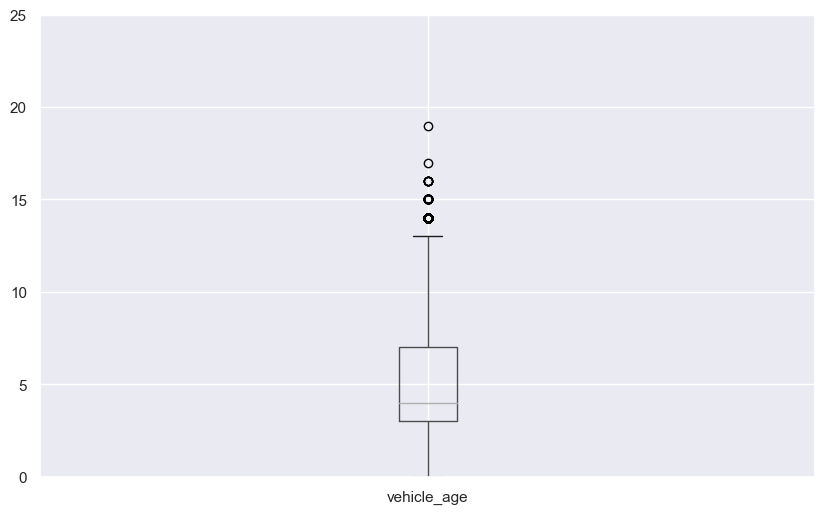

In [102]:
plt.ylim(0, 25)
plt.xlim(0, 2) 
df.boxplot(column='vehicle_age');

Выше верхнего уса лежит небольшое число данных. Посмотрим на них

In [103]:
Q1 = df['vehicle_age'].quantile(0.25)
Q3 = df['vehicle_age'].quantile(0.75)
IQR = Q3 - Q1
df[df['vehicle_age'] > Q3 + 1.5*IQR]['vehicle_age'].sort_values().to_frame()

,vehicle_age
176,14.0
32688,14.0
32628,14.0
32575,14.0
32441,14.0
...,...
30494,16.0
14107,17.0
44921,19.0
30623,161.0


Посмотрим на процент автомобилей, котором больше 50 лет

In [104]:
print(round(df[df['vehicle_age'] > 50]['vehicle_age'].count()/ df['vehicle_age'].count() * 100, 2), '%')

0.0 %


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51028 entries, 0 to 51027
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              51028 non-null  float64
 1   intersection          51028 non-null  int64  
 2   weather_1             51028 non-null  object 
 3   road_surface          51028 non-null  object 
 4   road_condition_1      51028 non-null  object 
 5   lighting              51028 non-null  object 
 6   at_fault              51028 non-null  int64  
 7   party_sobriety        51028 non-null  object 
 8   vehicle_type          51028 non-null  object 
 9   vehicle_transmission  51028 non-null  object 
 10  vehicle_age           51028 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 4.3+ MB


Автомобилей с аномальным возрастом нет. Не будем их трогать

#### Столбец `vehicle_transmission`:

In [106]:
df.vehicle_transmission.describe()

count      51028
unique         2
top       manual
freq       26907
Name: vehicle_transmission, dtype: object

In [107]:
df.vehicle_transmission.unique()

array(['auto', 'manual'], dtype=object)

In [108]:
df.groupby(by='vehicle_transmission')['vehicle_transmission'].count()

vehicle_transmission
auto      24121
manual    26907
Name: vehicle_transmission, dtype: int64

Аномалий не наблюдается

#### Столбец `vehicle_type`:

In [109]:
df.vehicle_type.describe()

count     51028
unique        3
top       sedan
freq      33680
Name: vehicle_type, dtype: object

In [110]:
df.vehicle_type.unique()

array(['sedan', 'coupe', 'other'], dtype=object)

In [111]:
df.groupby(by='vehicle_type')['vehicle_type'].count()

vehicle_type
coupe    17346
other        2
sedan    33680
Name: vehicle_type, dtype: int64

Рассмотрим данные со значением `other`

In [112]:
df[df['vehicle_type'] == 'other']

,distance,intersection,weather_1,road_surface,road_condition_1,lighting,at_fault,party_sobriety,vehicle_type,vehicle_transmission,vehicle_age
25940,0.0,1,clear,dry,normal,daylight,1,had not been drinking,other,manual,6.0
32865,239.0,0,cloudy,dry,normal,daylight,1,had not been drinking,other,manual,3.0


Оставим эти данные, так как может быть так, что `other` повлияет на итоговый результат предсказания

#### Столбец `at_fault` – целевой признак:

In [113]:
df.at_fault.describe()

count    51028.000000
mean         0.502998
std          0.499996
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: at_fault, dtype: float64

In [114]:
df.at_fault.unique()

array([0, 1])

In [115]:
df.groupby(by='at_fault')['at_fault'].count()

at_fault
0    25361
1    25667
Name: at_fault, dtype: int64

Дисбаланса классов (1 и 0) нет, аномалий также не обнаружено

### Проверим, имеются ли дубликаты:

In [116]:
df.duplicated().sum()

23127

Весьма много. Исключим дубликаты:

In [117]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27901 entries, 0 to 51027
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              27901 non-null  float64
 1   intersection          27901 non-null  int64  
 2   weather_1             27901 non-null  object 
 3   road_surface          27901 non-null  object 
 4   road_condition_1      27901 non-null  object 
 5   lighting              27901 non-null  object 
 6   at_fault              27901 non-null  int64  
 7   party_sobriety        27901 non-null  object 
 8   vehicle_type          27901 non-null  object 
 9   vehicle_transmission  27901 non-null  object 
 10  vehicle_age           27901 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 2.6+ MB


#### Вывод

Данные не содержат много шума, однако достаточно дубликатов. По этой причине размер выборки уменьшился в два раза. Данные содержат большое количество категориальных признаков, что не всегда удобно при анализе данных. Разработчикам системы сбора данных можно вынести предложение о том, что необходимо больше количественных признаков.

### Разбиение на выборки и масштабирование:

Разобъём данные на выборки:

In [119]:
features = df.drop('at_fault', axis=1)
target = df['at_fault']

features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42, shuffle=True)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.3, random_state=42, shuffle=True)

features_train.reset_index(drop=True, inplace=True)
features_valid.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)

print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(14647, 10) (14647,)
(6278, 10) (6278,)
(6976, 10) (6976,)


### Переведём категориальные данные в количественные:

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27901 entries, 0 to 51027
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              27901 non-null  float64
 1   intersection          27901 non-null  int64  
 2   weather_1             27901 non-null  object 
 3   road_surface          27901 non-null  object 
 4   road_condition_1      27901 non-null  object 
 5   lighting              27901 non-null  object 
 6   at_fault              27901 non-null  int64  
 7   party_sobriety        27901 non-null  object 
 8   vehicle_type          27901 non-null  object 
 9   vehicle_transmission  27901 non-null  object 
 10  vehicle_age           27901 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 2.6+ MB


In [121]:
categorical = ['weather_1',
               'road_surface',
               'road_condition_1', 
               'lighting', 
               'party_sobriety', 
               'vehicle_type',
               'vehicle_transmission',
               'vehicle_age']

Используем OneHotEncoder():

In [122]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

In [123]:
features_train.isnull().sum()

distance                0
intersection            0
weather_1               0
road_surface            0
road_condition_1        0
lighting                0
party_sobriety          0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

In [124]:
features_valid.isnull().sum()

distance                0
intersection            0
weather_1               0
road_surface            0
road_condition_1        0
lighting                0
party_sobriety          0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

In [125]:
features_test.head(3)

,distance,intersection,weather_1,road_surface,road_condition_1,lighting,party_sobriety,vehicle_type,vehicle_transmission,vehicle_age
0,9926.0,0,clear,dry,normal,dark with street lights,had been drinking,coupe,manual,3.0
1,574.0,0,clear,dry,normal,dark with no street lights,impairment unknown,coupe,manual,3.0
2,0.0,1,raining,wet,normal,daylight,had not been drinking,coupe,manual,9.0


In [126]:
features_train.columns

Index(['distance', 'intersection', 'weather_1', 'road_surface',
       'road_condition_1', 'lighting', 'party_sobriety', 'vehicle_type',
       'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [127]:
df.columns

Index(['distance', 'intersection', 'weather_1', 'road_surface',
       'road_condition_1', 'lighting', 'at_fault', 'party_sobriety',
       'vehicle_type', 'vehicle_transmission', 'vehicle_age'],
      dtype='object')

In [128]:
encoder.fit(features_train[categorical].to_numpy())


transformed = encoder.transform(features_train[categorical].to_numpy())
ohe_df = pd.DataFrame(transformed.toarray(), columns=encoder.get_feature_names_out())
features_train = pd.concat([features_train, ohe_df], axis=1).drop(categorical, axis=1)

transformed = encoder.transform(features_valid[categorical].to_numpy())
ohe_df = pd.DataFrame(transformed.toarray(), columns=encoder.get_feature_names_out())
features_valid = pd.concat([features_valid, ohe_df], axis=1).drop(categorical, axis=1)

transformed = encoder.transform(features_test[categorical].to_numpy())
ohe_df = pd.DataFrame(transformed.toarray(), columns=encoder.get_feature_names_out())
features_test = pd.concat([features_test, ohe_df], axis=1).drop(categorical, axis=1)

Масштабируем данные:

In [129]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

<div class="alert alert-block alert-warning">
<b>Комментарий от ревьюера v1</b> ⚠️ 
    
Нет необходимости масштабировать признаки, закодированные OHE
    
Кроме того, для облегчения обработки данных можно использовать [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html#sklearn.compose.make_column_transformer) или [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). Этот инструмент можно встраивать в [пайплайны](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) для автоматизации и улучшения качества предобработки данных и разработки моделей..
    
[Здесь](https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing#scrollTo=organized-pierce) есть пример того, как кодируются и масштабируются признаки.

### Обучение моделей

Везде будем использовать метрику `Recall`, так как нам очень важно предсказывать максимально большое количество тех случаев, когда авария действительно будет. Выписать же предупреждение аккуратному водителю не страшно, хуже от напоминания о безопасности не станет. 

#### Модель LGBMClassifier:

Обучим модель:

In [130]:
%%time
best_rec = 0
best_est = 0
best_model_lgbm = None

    
for est in range(5, 12, 3):

    model = LGBMClassifier(n_estimators = est, objective='binary', boosting_type = 'gbdt')
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    rec_score = rec(target_valid, predictions)
    
    if best_rec < rec_score:
        best_rec = rec_score
        best_est = est
        best_model_lgbm = model
        
    print(f'est = {est}')
    print(f'rec_score = {rec_score}')

best_rec_lgbm_valid = best_rec
        
print(f'best_est = {best_est}')
print(f'best_rec_lgbm_valid = {best_rec_lgbm_valid}')

est = 5
rec_score = 0.7957435046987286
est = 8
rec_score = 0.7487562189054726
est = 11
rec_score = 0.7001105583195135
best_est = 5
best_rec_lgbm_valid = 0.7957435046987286
CPU times: user 419 ms, sys: 175 ms, total: 594 ms
Wall time: 96.5 ms


Результаты подозрительно хорошие. Кажется, что dummy ловушки нет. И утечки таргета не наблюдается.

Далее по аналогии исследуем ещё 2 модели.

#### Модель LogisticRegression:

In [131]:
%%time
best_rec = 0
best_C = 0
best_model_lr = None
a = 1e-10
b = 1
n = 10
for j in range(n + 1):
    CC = a + j*(b - a)/n
    model = LogisticRegression(random_state=99999999, solver='lbfgs', C=CC, class_weight='balanced') 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rec_score = rec(target_valid, predictions)
    
    if best_rec < rec_score:
        best_rec = rec_score
        best_C = CC
        best_model_lr = model

best_rec_lr_valid = best_rec
        
print(f'best_C = {best_C}')
print(f'best_rec_lr_valid = {best_rec_lr_valid}')

best_C = 0.40000000006
best_rec_lr_valid = 0.5223880597014925
CPU times: user 3.26 s, sys: 206 ms, total: 3.47 s
Wall time: 473 ms


#### Модель RandomForest:

In [132]:
best_rec = 0
best_depth = 0
best_est = 100
best_model_rf = None

for depth in range(1,10):    
    model = RandomForestClassifier(random_state=77766613, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)

    predictions = model.predict(features_valid)
    rec_score = rec(target_valid, predictions)
    
    if best_rec < rec_score:
        best_rec = rec_score
        best_depth = depth
        best_model_rf = model
    
for est in range(1, 10):

    model = RandomForestClassifier(random_state=15878934, n_estimators=est, max_depth=best_depth, class_weight='balanced')
    model.fit(features_train, target_train)
    
    predictions = model.predict(features_valid)
    rec_score = rec(target_valid, predictions)
    
    if best_rec < rec_score:
        best_rec = rec_score
        best_est = est
        best_model_rf = model

        
print(f'best_depth = {best_depth}')
print(f'best_est = {best_est}')

best_rec_rf_valid = best_rec

print(f'best_rec_rf_valid = {best_rec_rf_valid}')

best_depth = 1
best_est = 1
best_rec_rf_valid = 0.9527363184079602


Итак, лучшие результаты показала модель `lgbm`:

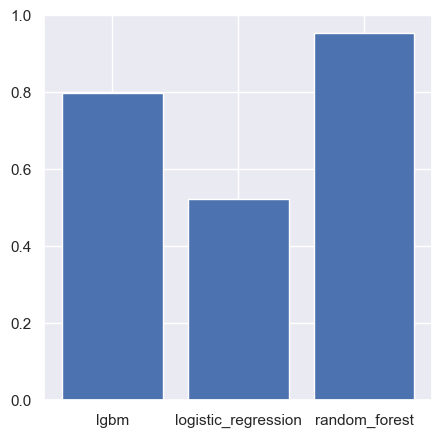

In [133]:
ax.set_facecolor('seashell')

names = ['lgbm', 'logistic_regression', 'random_forest']
values = [best_rec_lgbm_valid, best_rec_lr_valid, best_rec_rf_valid]

plt.figure(figsize=(5, 5))

plt.bar(names, values)
plt.show()

Результаты лучшей модели на тестовой выборке:

In [134]:
predictions = best_model_lgbm.predict(features_test)

print(f'best_model_test = {rec(target_test, predictions)}')

best_model_test = 0.7993842996408415


## Проведите анализ важности факторов ДТП

Матрица ошибок для лучшей модели:

In [135]:
predictions = best_model_lgbm.predict(features_test)

In [136]:
cm = confusion_matrix(target_test, predictions)

In [137]:
cm

array([[1313, 1765],
       [ 782, 3116]])

[Text(0, 0.5, 'Не виновен'), Text(0, 1.5, 'Виновен')]

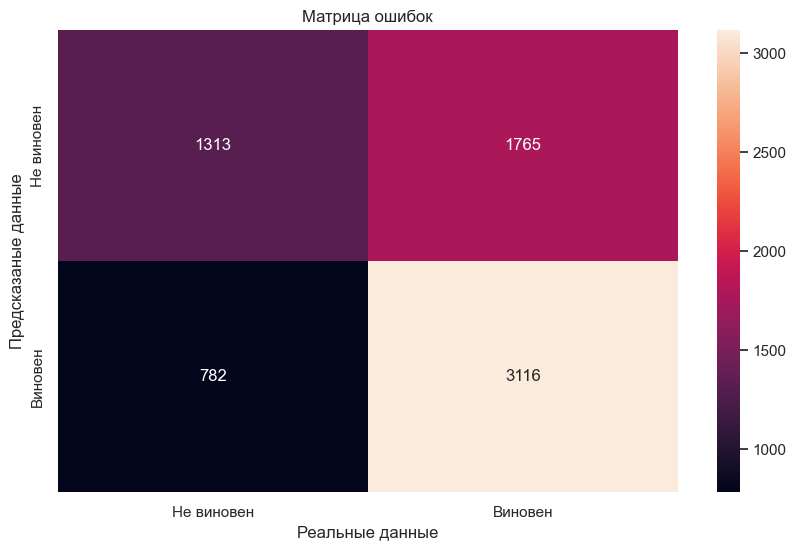

In [138]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

ax.set_xlabel('Реальные данные');
ax.set_ylabel('Предсказаные данные'); 
ax.set_title('Матрица ошибок'); 
ax.xaxis.set_ticklabels(['Не виновен', 'Виновен']); 
ax.yaxis.set_ticklabels(['Не виновен', 'Виновен'])

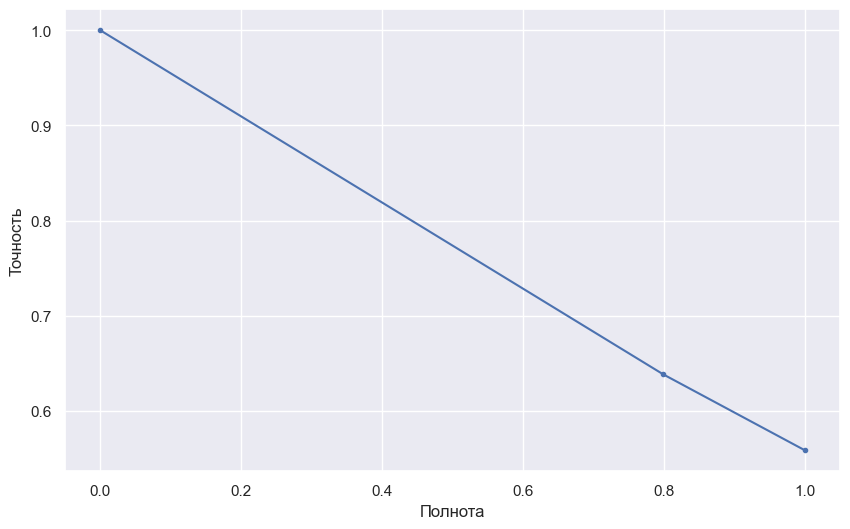

In [139]:
ax.set_facecolor('seashell')
precision, recall, _ = precision_recall_curve(target_test, predictions)

pyplot.plot(recall, precision, marker='.')

pyplot.xlabel('Полнота')
pyplot.ylabel('Точность')
pyplot.show()

В поставленной задаче требовалось проанализировать важность основных факторов, влияющих на вероятность ДТП. Как это сделать в случае такого большого количества категориальных переменных как унас я не имею понятия. Однако для удовлетворения воли составителей сделаем максимально тупой ход:

Посмотрим, с чем сильнее всего коррелирует целевой признак:

In [140]:
df.corr()

,distance,intersection,at_fault,vehicle_age
distance,1.000000,-0.131545,0.044712,0.035911
intersection,-0.131545,1.000000,-0.005038,0.054273
at_fault,0.044712,-0.005038,1.000000,-0.069648
vehicle_age,0.035911,0.054273,-0.069648,1.000000


Наиболее сильная корреляция с фактом принятия алкоголя.

Решение проблемы: ужесточить наказание. Страх заставит особенно неразумных водителей не пить перед поездками.

### Дополнительный анализ важных факторов влияющих на ДТП

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27901 entries, 0 to 51027
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              27901 non-null  float64
 1   intersection          27901 non-null  int64  
 2   weather_1             27901 non-null  object 
 3   road_surface          27901 non-null  object 
 4   road_condition_1      27901 non-null  object 
 5   lighting              27901 non-null  object 
 6   at_fault              27901 non-null  int64  
 7   party_sobriety        27901 non-null  object 
 8   vehicle_type          27901 non-null  object 
 9   vehicle_transmission  27901 non-null  object 
 10  vehicle_age           27901 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 2.6+ MB


Функция отбора признаков и построения столбчатой диаграммы

In [142]:
def explore_influence(string_col):
    dict_cols = {}
    col_party_sobriety = df[string_col].unique().tolist()
    dict_cols[string_col] = col_party_sobriety
    col_at_fault = df.at_fault.unique().tolist()
    dict_cols['at_fault'] = col_at_fault
    dict_df = {}
    for col1 in dict_cols[string_col]:
        for col2 in dict_cols['at_fault']:
            num_value = df[(df[string_col] == col1) & (df['at_fault'] == col2)]['at_fault'].count()
            key_d = '{}_{}'.format(col1, col2)
            dict_df[key_d] = num_value

    yer = pd.DataFrame(data=dict_df, index=[0])
    sns.barplot(data=yer)

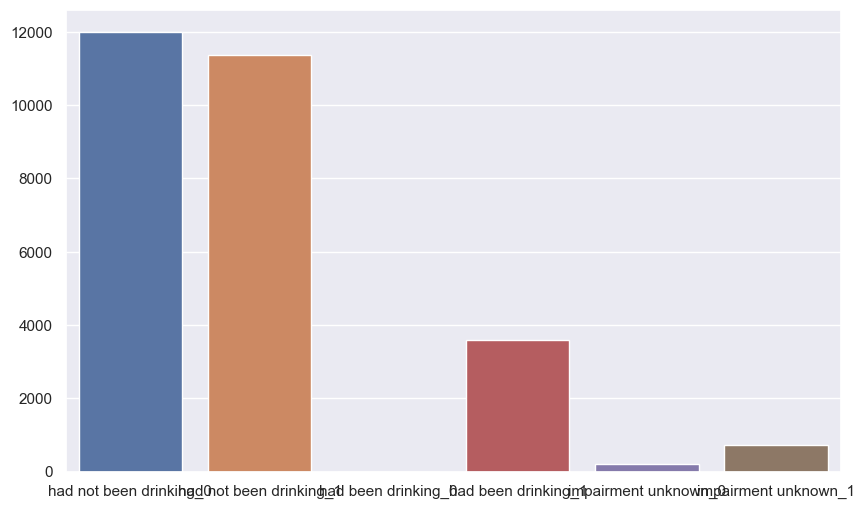

In [143]:
explore_influence('party_sobriety')

Не выпившие и те кто употребил алкоголь примерно одинаково попадают в ДТП. Однако те кто выпил попадают в аварию всегда. Это действительно может быть наиболее значимый признак в ДТП

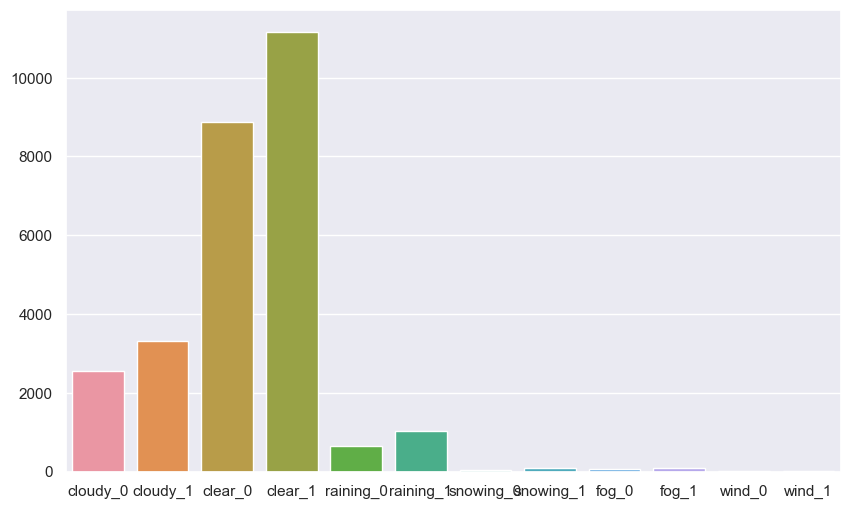

In [144]:
explore_influence('weather_1')

Состояние погоды судя по всему не особо влияет на ДТП

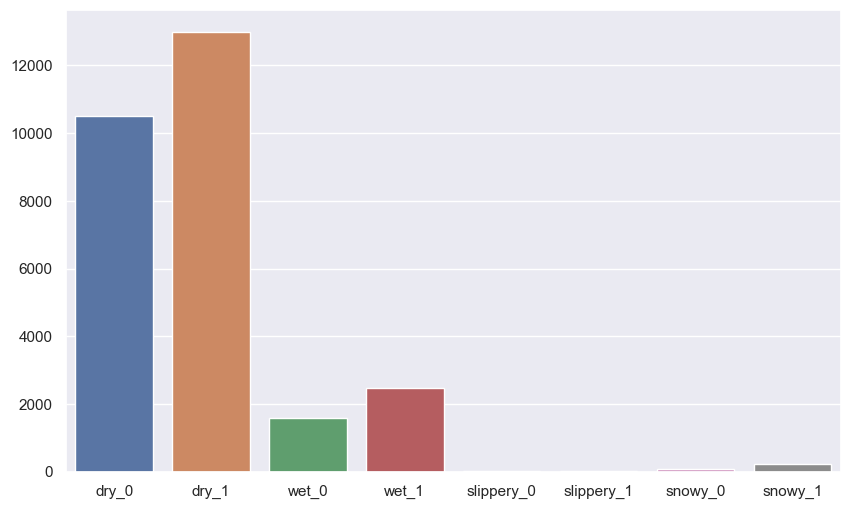

In [145]:
explore_influence('road_surface')

Состояние дороги также судя по всему не особо влияет на ДТП

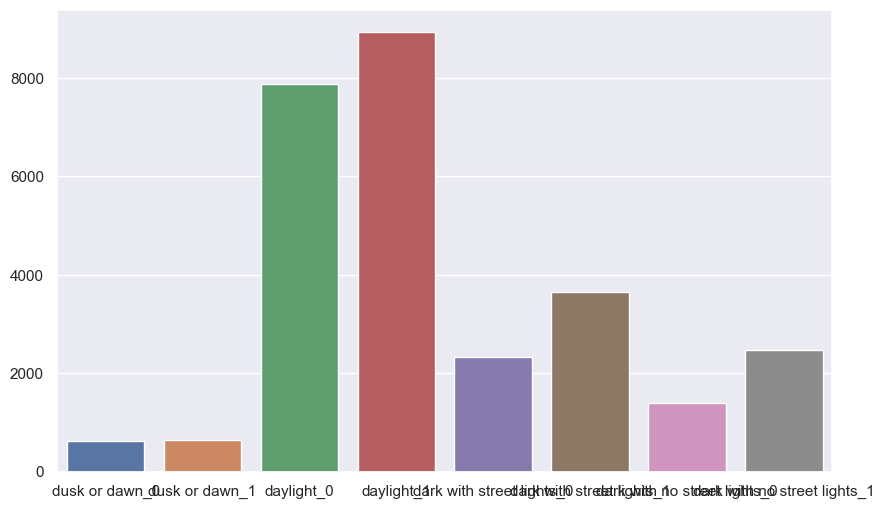

In [146]:
explore_influence('lighting')

Аварии происходят больше всего в дневное время суток

## Выводы

Наилучшая модель `lgbm`. Создание адекватной системы оценки риска при выдаче авто невозможно: все модели проявили себя плохо. Для решения проблемы требуется более продвинутое исследование и обработка данных.

Однако стоит отметить, что требуется дополнительные признаки для того, чтобы разработать более качественную модель, а именно: 
- Количество пассажиров в автомобиле
- Длительность поездки до аварии
- Количество штрафов (желательно разбить на признаки каждый тип штрафа) у каждого водителя
- Были ли исправны габариты автомобиля
- Скорость автомобиля на протяжении поездки (есть технические трудности, так как необходимо разработать датчик, который бы выводил риск аварии в реальном времени)
